# A Restricted Boltzmann Machine for protein encoding 
## Assignment for the Laboratory of Computational Physics (mod. B) class

**March 2023**

- Veronica Bedin, 2097013
- Roben Bhatti, 2091187
- Diego Bonato, 2091250
- Michail Sapkas, 2072109

# How to use RBM class

### Class methods:

**rbm** ( *data, hidden_units=2, SPINS=True, random_seed=2303* )
- Initializes a Restricted Boltzmann Machine instance.

*example*: my_rbm = rbm.( *args* )

1. data: Expects the user to give the whole dataset. The class will automatically compute the visible layer needed.
2. hidden_units: Specify the number of hidden units
3. SPINS: True for usage of spin notation {-1,1}, False for {0,1} respresentation
4. random_seed: Passes the random seed

**object_instance.train** ( *epochs=100, learning_rate=1.0, power_law=True, bach_size=500, cd=0, optimizer='sgd', verbose=True, beta1=0.9, beta2=0.999, epsilon=2, gamma=0.9, keep_best=True* ) 
- Trains the instanciated object on the data passed at initialization

*example*: my_rbm.train( *args* )

1. epochs: How many epochs to train on
2. learning_rate: Learning rate hyperparameter. For SGD should use 1, for ADAM less than 1
3. power_law: Only avaible with SGD. True if to be used, False for not
4. batch_size: Minibatch size to be used
5. cd: Number of contrastive divergence steps to be used. If cd < 1 , only 1 step will be used
6. optimizer: Avaible options, given as strings, are:
    1. 'sgd' 
    2. 'adam'
    3. 'adagrad'
    4. 'rmsprop'
7. verbose: If True will output learning rate and a graph during training
8. epsilon: If choose ADAM for optimizer the user can tune the epsilon hyperparameter
9. gamma: If choose RMSprop for optimizer the user can tune the epsilon hyperparameter
10. keep_best: If True, it tracks the weights and biases that gave the max energy and replaces them at the end of the training

**object_instance.generate** ( *amplify=40, one_hot=True* )
- Once trained, generates data from the model

1. aplify: How much to apply amplification of the energy in data generation
2. one_hot: if True preserves the one hot enconding, if False it doesn't care

**object_instance.accuracy** ( *gen_data* )
- Since we have knowledge if how the data should be, we can compare the generated data with the ideal case of N-P-N-P-N or P-N-P-N-P chains and get an accuracy.

1. gen_data: expects the generated data to be passed as an argument

**object_instance.plot_denoised** ( *fname, generated_data, n_rows=12, block_size=4, polar=False* )
- Once data have been generated, using the above method, attempts to plot the original and generated (denoised) data

1. fname: expectes the filename generated in the original code - use the custom loading data function to aquire fname
2. generated_data: after using the generate method, pass the generated data here
3. n_rows: how many rows to plot
4. block_size: number of columns to use to define a "block". Not relevant if polar=False
5. polar: if True, applies the N-P representation of the data. Very usefull to visually explore errors. 

### Class variables:
- This is a list of all the variable tracked by the model. The user can extract usefull information by invoking:

**object_instance.VARIABLE**

- The list of variables tracked by the model are:
1. w (weights)
2. a (visible layer biases)
3. b (hidden layer biases)
4. optimizer_title (used optimizer name)
5. energy_model (energy of the model at the end of each mini batch)
6. energy_data (energy of the data at the end of each mini batch)
7. log_likelihood (the log likelihood at the end of each epoch)
8. entropy (the entropy at the end of each epoch)


### For plotting the graphs:

- The epoch argument only affects the title of the graph.

**object_instance.plotgraph_vert** ( *epoch* )
- Plots horizontal graph

**object_instance.plotgraph** ( *epoch* )
- Plots vertical graph. Used by train method, if verbose=True


Importing the RBM class and the libraries used

In [1]:
#from RBM import rbm
from DIEGORBM import rbm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import display_html 
import pandas as pd
import itertools
import seaborn as sns
plt.rcParams['font.size'] = 14

This custom function loads the data and also returns the filename necessery for plotting

In [2]:
def load_data(CASE):
    if CASE==0: dname="DATA"
    if CASE==1: dname="DATA_b"

    fname=dname+'/x_RBM_q0.1.dat'
    # loading data: each row is a list of visible units
    # NOTE: data "x" here is named "v" for "visible"
    v = np.loadtxt(fname, delimiter=" ",dtype=int)
    return v , fname

Also some custom functions to plot energies, log likelihood and entropy

In [3]:
def plot_energies(model):  
    x = np.linspace(0,50,len(model.energy_model))
    mean = np.mean(model.energy_model)
    #asy = model.energy_model[-1]
        
    plt.plot(x,model.energy_model,label='Model', linewidth=1.3)
    plt.plot(x,model.energy_data,label='Data', linewidth=1.3)
    plt.plot(x,np.full(len(x),mean),'--',label='Model Mean',c='r',linewidth=1.5)
    #plt.plot(x,np.full(len(x),asy),'--',label='asy_model',c='y',linewidth=0.8)

    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.show()
        
def plot_log_likelihood(model):
    x = np.arange(len(model.log_likelihood))
    mean = np.mean(model.log_likelihood)
    asy = model.log_likelihood[-1]
        
    plt.plot(model.log_likelihood,label='Log Likelihood', linewidth=1.3)
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_log_likelihood',c='orange',linewidth=1.5)
        
    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Likelihood')
    plt.yticks([-9,-8,-7,model.log_likelihood[-1]])
    plt.show()

def plot_entropy(model):
    x = np.arange(len(model.entropy))
    mean = np.mean(model.entropy)
    asy = model.entropy[-1]
        
    plt.plot(model.entropy,label='Entropy')
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_entropy',c='orange',linewidth=1.5)
        
    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.yticks([0.01,0.02,0.03,model.entropy[-1]])
    plt.show()


# Exploring {0,1} and {-1,1} representation
In the rbm class this is equivilent to SPINS=False for {0,1} and SPINS=True for {-1,1} . We will preserve the one hot encoding.

In [4]:
data, fname = load_data(CASE=1)

{0,1}

In [5]:
rbm = rbm(data, hidden_units=3, SPINS=False, random_seed=220)

Loaded N=10000 data instances each containing L=20 digits


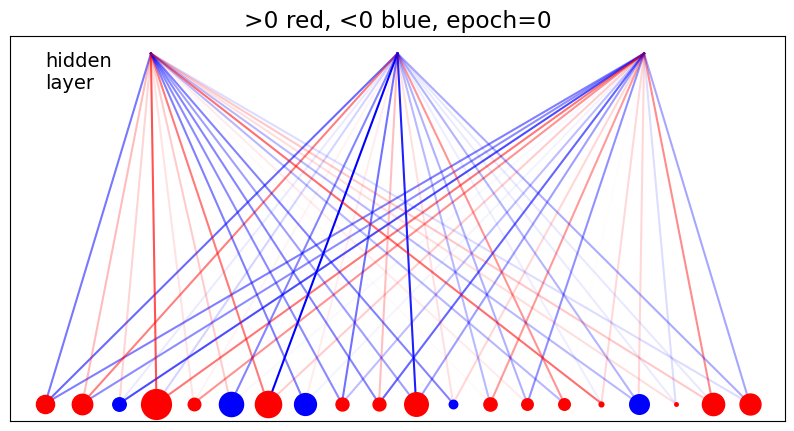

learning rate =  0.005
epoch:  1
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.408
epoch:  2
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.25
epoch:  3
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.203
epoch:  4
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.18
epoch:  5
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.165
epoch:  6
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.152
epoch:  7
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.144
epoch:  8
====|====|====|====|====|====|=

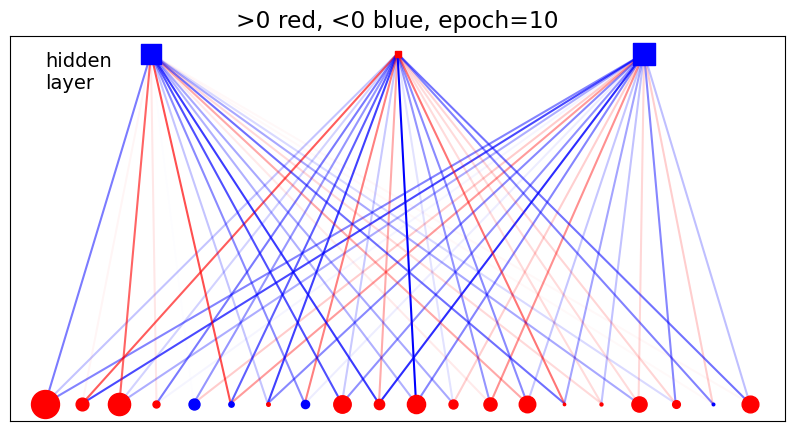

learning rate =  0.005
epoch:  11
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.128
epoch:  12
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.126
epoch:  13
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.123
epoch:  14
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.121
epoch:  15
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.12
epoch:  16
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.119
epoch:  17
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.118
epoch:  18
====|====|====|====|==

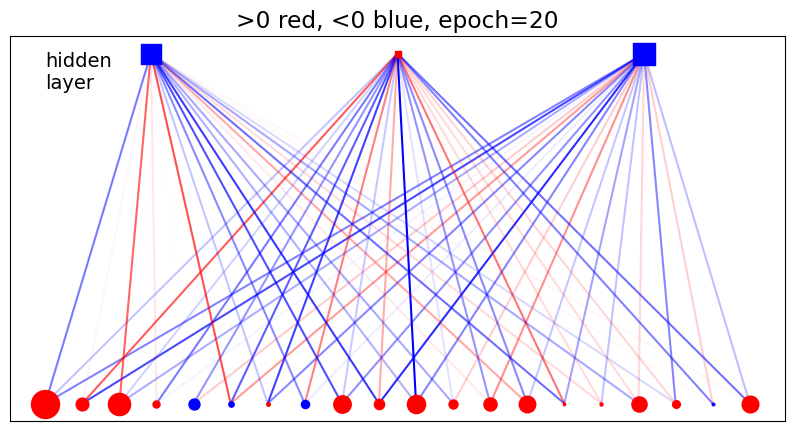

learning rate =  0.005


In [6]:
rbm.train(epochs=20, 
          one_hot=True, 
          learning_rate=0.005, 
          batch_size=500, 
          cd=5, 
          optimizer='adam', 
          epsilon=2,
          keep_best=True,
          verbose=True)

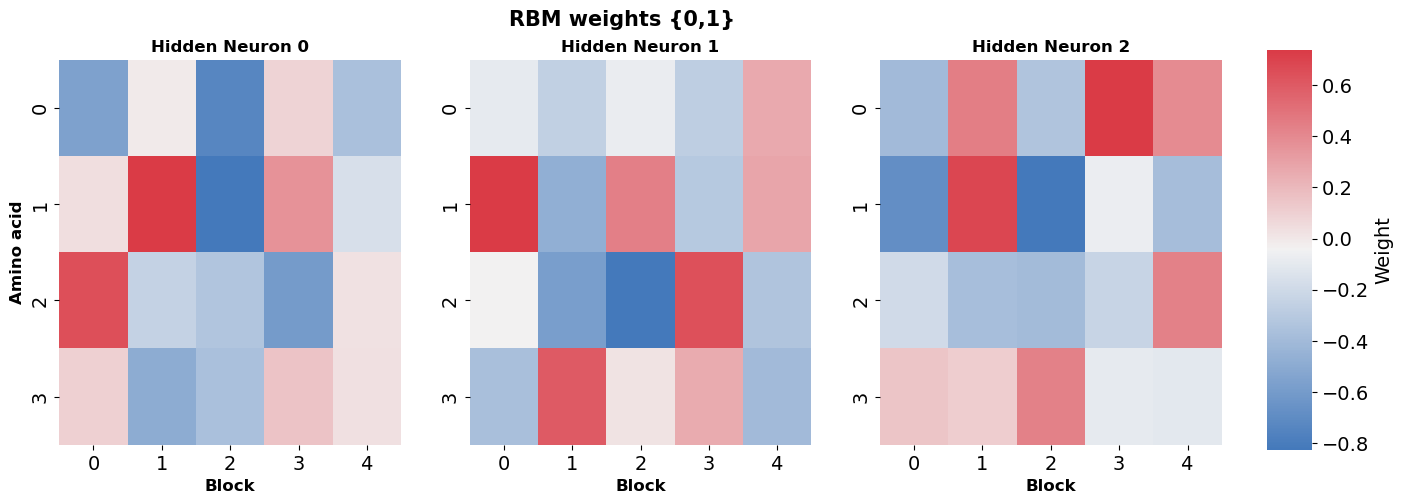

In [7]:
rbm.plot_weights(SPINS=False)